In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [38]:

import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
trainset = "processed/train.h5"
valset = "processed/test.h5"
testset= "processed/test.h5"
#!wget https://repository.library.northeastern.edu/downloads/neu:4f24c004s?datastream_id=content
#!cp drive/MyDrive/colab/signal_bank.zip .
#!unzip signal_bank.zip
#!cp processed/* drive/MyDrive/colab/
#!mkdir processed
#!cp drive/MyDrive/colab/*.h5 processed/

In [1]:
from typing_extensions import TypeVarTuple
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

###################################
### PROJECT SPECIFIC PARAMETERS ###
###################################

#if enabled will plot a sample
debug = False
#total number of training/testing samples to generate
nsamples = 50_000
#max number of signals to be plotted at the same time in frequency
max_simultaneous_signals = 2
#total observable bandwidth (for our signal bank this needs to be a multiple of 25MHz)
bw = 25_000_000
#input size to the NN (for our signal bank this needs to be a multiple of 1024)
buf = 1024
#frequency resolution or bw of a single bin in the NN input
resolution = (bw/1000000)/buf
#probabliity that the entire observable bandwith doesnt contain any signal
prob_empty = 0.05
#probability that the first signal injected into the input is centered
prob_centered = 0.5

nclasses = 5

#dict containing indexes of rows belonging to each protocol in classification label matrix
#(note "empty" doesnt get its own row in the matrix) you can think of these as class labels
#where each value corresponds to the row that will contain 1 in columns/IQs where that signal is present
#and 0 where it isnt
label_dict_str= {
    'wifi'      : 0,
    'lte'       : 1,
    'zigbee'    : 2,
    'lora'      : 3,
    'ble'       : 4
}

#flipped version of above dict
label_dict_int = dict([(value, key) for key, value in label_dict_str.items()])

#dict of bw for each signal in mhz
signal_bw_mhz_dict = {
    'wifi'      : 20,
    'lte'       : 10,
    'zigbee'    : 2,
    'lora'      : 0.5,
    'ble'       : 1
}

#dict of bw for each signal in number of IQs
signal_bw_mhz_niqs = {}
for label in signal_bw_mhz_dict:
    niqs = np.ceil(signal_bw_mhz_dict[label]/resolution)

    if niqs%2 == 1:
        niqs += 1

    signal_bw_mhz_niqs[label] = int(niqs)

#path to signal bank dir
#each class should have its own h5 file i.e. lora.h5, wifi.h5 etc
data_fp = './signal_bank/'
final_folder_fp = './processed/'
if not os.path.isdir(final_folder_fp):
    os.mkdir(final_folder_fp)

###################################
### PROJECT SPECIFIC PARAMETERS ###
###################################


#grab random signal from signal bank
def get_sample(protocol):
    f_signal = h5py.File(data_fp + protocol + '.h5', 'r')
    samp = f_signal[protocol][np.random.randint(f_signal[protocol].shape[0])]
    f_signal.close()
    return samp


if __name__ == '__main__1':

    all_labels = []
    all_inputs = []

    #if you want to omit a class you can remove them from below list
    protocols_used = [0,1,2,3,4]
    for i in tqdm(range(nsamples)):
        label = np.zeros([nclasses,buf], dtype=int)
        input_samp = np.zeros([buf, 2])

        if np.random.rand() > prob_empty:
            nsignals = np.random.randint(1,max_simultaneous_signals+1)

            signal_protocols = np.zeros(nsignals)
            signal_freqs = np.zeros(nsignals)
            prev_centered = False

            for j in range(nsignals):
                protocol = np.random.choice(protocols_used)
                signal_protocols[j] = protocol

                signal_bw = signal_bw_mhz_niqs[label_dict_int[protocol]]
                temp_input = np.zeros([buf+signal_bw*2-2,2])

                samp = get_sample(label_dict_int[protocol])
                samp_cut = samp[buf//2-signal_bw//2:buf//2+signal_bw//2,:]

                if np.random.rand() < prob_centered and not prev_centered:
                    signal_location = int(len(temp_input)/2-signal_bw/2)
                    prev_centered = True
                else:
                    signal_location = int(np.random.choice(len(temp_input)-signal_bw+1))



                temp_mask = np.zeros(buf+signal_bw*2-2, dtype=bool)
                temp_mask[signal_location:signal_location + signal_bw] = True

                signal_freqs[j] = signal_location*resolution

                temp_input[signal_location:signal_location+signal_bw,:] += samp_cut
                label[protocol] |= temp_mask[signal_bw-1:signal_bw+buf-1]
                input_samp += temp_input[signal_bw-1:signal_bw+buf-1,:]


        input_samp += get_sample('empty')
        all_inputs.append(input_samp)
        all_labels.append(label)


        if debug:
            plt.plot(np.linspace(-bw/1_000_000/2,bw/1_000_000/2,buf),abs(input_samp[:,0] + 1j*input_samp[:,1]))
            plt.xlabel('MHz')
            plt.title(signal_protocols)
            plt.show()

    all_inputs = np.array(all_inputs)
    all_labels = np.array(all_labels)

    X_train, X_test, y_train, y_test = train_test_split(
        all_inputs, all_labels, test_size=0.1, random_state=42)

    f_test = h5py.File(
        final_folder_fp + 'test.h5', 'w')
    xtest = f_test.create_dataset('X', (X_test.shape[0], X_test.shape[1], X_test.shape[2]), dtype='f')
    ytest = f_test.create_dataset('y', (y_test.shape[0],y_test.shape[1], y_test.shape[2]), dtype='i')

    xtest[()] = X_test
    ytest[()] = y_test

    f_train = h5py.File(
        final_folder_fp + 'train.h5', 'w')
    xtrain = f_train.create_dataset('X', (X_train.shape[0], X_train.shape[1], X_train.shape[2]), dtype='f')
    ytrain = f_train.create_dataset('y', (y_train.shape[0],y_train.shape[1], y_train.shape[2]), dtype='i')

    xtrain[()] = X_train
    ytrain[()] = y_train

    f_test.close()
    f_train.close()

In [2]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

class conv_block(nn.Module):
    def __init__(self,in_channel,out_channel) -> None:
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channel,out_channel,3,1,1),
            nn.BatchNorm1d(out_channel),
            nn.ReLU(),
            nn.Conv1d(out_channel,out_channel,3,1,1),
            nn.BatchNorm1d(out_channel),
            nn.ReLU()
        )
    def forward(self,input):
        return self.conv(input)

class up_conv(nn.Module):
    def __init__(self,in_channel,out_channel) -> None:
        super(up_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channel,out_channel,3,1,1),
            nn.BatchNorm1d(out_channel),
            nn.ReLU()
        )

    def forward(self,input):
        return self.conv(input)

class NonLocal1D(nn.Module):
    def __init__(self, in_channels) -> None:
        super(NonLocal1D, self).__init__()
        self.in_channels = in_channels
        self.inter_channels = in_channels//2 # bottleneck design (see section 3.3)

        self.theta = nn.Conv1d(self.in_channels, self.inter_channels, 1)
        self.phi = nn.Sequential(
            nn.Conv1d(self.in_channels, self.inter_channels, 1),
            nn.MaxPool1d(2), # maxpool to reduce computation to 1/4 (see section 3.3)
        )
        self.g = nn.Sequential(
            nn.Conv1d(self.in_channels, self.inter_channels, 1),
            nn.MaxPool1d(2),
        )

        self.wz = nn.Sequential(
            nn.Conv1d(self.inter_channels, self.in_channels, 1),
            nn.BatchNorm1d(self.in_channels),
        )
        nn.init.constant_(self.wz[1].weight, 0) # zero initialization (see section 3.3)
        nn.init.constant_(self.wz[1].bias, 0)

    def forward(self, input):
        g = self.g(input).view(input.size(0),self.inter_channels,-1)
        g = g.permute(0,2,1)

        theta = self.theta(input).view(input.size(0),self.inter_channels,-1)
        theta = theta.permute(0,2,1)

        phi = self.phi(input).view(input.size(0),self.inter_channels,-1)

        f = torch.matmul(theta,phi)
        f = nn.functional.softmax(f,dim=-1)

        y = torch.matmul(f,g)
        y = y.permute(0,2,1).contiguous()
        y = y.view(input.size(0),self.inter_channels,*input.size()[2:])

        wz = self.wz(y)

        return wz+input

class U_Net(nn.Module):
    def __init__(self,inchannel,outchannel,is_attention=False,alpha=1,beta=5) -> None:
        super(U_Net,self).__init__()
        self.is_attention = is_attention
        self.beta = beta
        self.pool = nn.MaxPool1d(2,2)
        self.conv1 = conv_block(inchannel,int(64*alpha))
        if self.beta > 1:
            self.conv2 = conv_block(int(64*alpha),int(128*alpha))
            if self.beta > 2:
                self.conv3 = conv_block(int(128*alpha),int(256*alpha))
                if self.beta > 3:
                    self.conv4 = conv_block(int(256*alpha),int(512*alpha))
                    if self.beta > 4:
                        self.conv5 = conv_block(int(512*alpha),int(1024*alpha))

                        self.upconv5 = up_conv(int(1024*alpha),int(512*alpha))
                        self.decode5 = conv_block(int(1024*alpha),int(512*alpha))

                    self.upconv4 = up_conv(int(512*alpha),int(256*alpha))
                    self.decode4 = conv_block(int(512*alpha),int(256*alpha))

                self.upconv3 = up_conv(int(256*alpha),int(128*alpha))
                self.decode3 = conv_block(int(256*alpha),int(128*alpha))

            self.upconv2 = up_conv(int(128*alpha),int(64*alpha))
            self.decode2 = conv_block(int(128*alpha),int(64*alpha))

        self.decode1 = nn.Conv1d(int(64*alpha),outchannel,1,1)
        if self.is_attention:
            self.nonlocal1 = NonLocal1D(outchannel)

    def forward(self,input):
        # encoder path
        e1 = self.conv1(input)
        if self.beta > 1:
            e2 = self.pool(e1)
            e2 = self.conv2(e2)
            if self.beta > 2:
                e3 = self.pool(e2)
                e3 = self.conv3(e3)
                if self.beta > 3:
                    e4 = self.pool(e3)
                    e4 = self.conv4(e4)
                    if self.beta > 4:
                        e5 = self.pool(e4)
                        e5 = self.conv5(e5)

                        d5 = self.upconv5(e5)
                        d5 = self.decode5(torch.cat((e4,d5),dim=1)) # channel first

                        d4 = self.upconv4(d5)
                        d4 = self.decode4(torch.cat((e3,d4),dim=1))
                    else:
                        d4 = self.upconv4(e4)
                        d4 = self.decode4(torch.cat((e3,d4),dim=1))

                    d3 = self.upconv3(d4)
                    d3 = self.decode3(torch.cat((e2,d3),dim=1))
                else:
                    d3 = self.upconv3(e3)
                    d3 = self.decode3(torch.cat((e2,d3),dim=1))

                d2 = self.upconv2(d3)
                d2 = self.decode2(torch.cat((e1,d2),dim=1))
            else:
                d2 = self.upconv2(e2)
                d2 = self.decode2(torch.cat((e1,d2),dim=1))

            d1 = self.decode1(d2)
        else:
            d1 = self.decode1(e1)

        if self.is_attention:
            d1 = self.nonlocal1(d1)

        return torch.sigmoid(d1)





In [30]:
class BinaryFocalLoss(nn.Module):
    def __init__(self,alpha=None,gamma=2, reduction=True) -> None:
        super(BinaryFocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCELoss(reduction="none")
        self.reduction = reduction
    def forward(self,y_pred,y_true):
        if self.alpha is not None:
            alpha = torch.where(y_true == 1.0, self.alpha, (1.0 - self.alpha))
        else:
            alpha = 1

        # Ensure that y_pred and y_true have the same shape before applying torch.where
        if y_pred.shape != y_true.shape:
            print("Warning: Shape mismatch between y_pred and y_true.")
            print("y_pred shape:", y_pred.shape)
            print("y_true shape:", y_true.shape)
            # Handle the shape mismatch (e.g., by resizing or broadcasting)
            # For example, if y_pred has an extra dimension:
            y_pred = y_pred.squeeze(1)  # Remove the extra dimension


        pt = torch.where(y_true == 1.0, y_pred, 1 - y_pred)
        bce = self.bce(y_pred,y_true)
        loss = alpha*torch.pow(1.0 - pt, self.gamma)*bce
        if self.reduction:
            return torch.mean(loss)
        return torch.mean(loss,dim=(1,2))

In [5]:
from torch.utils.data import Dataset
import h5py

class MultilabelDataset(Dataset):
    def __init__(self,h5file,norm=True) -> None:
        df = h5py.File(h5file)
        self.data = df['X']
        self.label = df['y']
        self.norm = norm
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = torch.from_numpy(self.data[idx].T)
        y = torch.from_numpy(self.label[idx][1:])
        return X, y

In [35]:
from multiprocessing import cpu_count
from torch.utils.data import DataLoader

class TrainValHandler():
    def __init__(self,model,device,trainset,valset,save_path,
                 alpha=None,gamma=0,ohem=False,
                 lr=1e-3,epochs=90,patience=50,batchsize=1024,nbatches=2) -> None:
        self.model = model
        self.device = device
        self.path = save_path
        self.trainset = MultilabelDataset(trainset)
        self.valset = MultilabelDataset(valset)

        self.loss = BinaryFocalLoss(alpha,gamma,reduction=not ohem)
        self.optim = torch.optim.Adam(self.model.parameters(),lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim,step_size=30,gamma=0.1)
        self.epochs = epochs
        self.patience = patience
        self.min_loss = torch.inf
        self.ohem = ohem
        self.batchsize = batchsize
        self.nbatches = nbatches

        try:
            workers = cpu_count()
        except:
            workers = 1
        if ohem:
            self.traindataloader = DataLoader(self.trainset,self.batchsize*self.nbatches,shuffle=True,num_workers=workers)
        else:
            self.traindataloader = DataLoader(self.trainset,self.batchsize,shuffle=True,num_workers=workers)
        self.valdataloader = DataLoader(self.valset,self.batchsize,shuffle=True,num_workers=workers)

    def save_model(self):
        path = self.path
        torch.save(self.model.state_dict(),path)

    def train_one_epoch(self):
        self.model.train()
        train_loss = 0
        for i, samples in enumerate(self.traindataloader):
            x,y = samples
            x = x.to(self.device,dtype=torch.float)
            y = y.to(self.device,dtype=torch.float)
            pred = self.model(x)
            if self.ohem:
                loss,_ = torch.topk(self.loss(pred,y),pred.shape[0]//self.nbatches)
                loss = torch.mean(loss)
            else:
                loss = self.loss(pred,y)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

            train_loss += loss.item()
            print('batch %d/%d, training loss %.6f' % (i+1,len(self.traindataloader),train_loss/(i+1)),end='\r')
        return train_loss/len(self.traindataloader)

    def val_one_epoch(self):
        self.model.eval()
        val_loss = 0
        for i, samples in enumerate(self.valdataloader):
            x,y = samples
            x = x.to(self.device,dtype=torch.float)
            y = y.to(self.device,dtype=torch.float)
            with torch.no_grad():
                pred = self.model(x)
                loss = self.loss(pred,y)
                if self.ohem:
                    loss = torch.mean(loss)
                val_loss += loss.item()
        return val_loss/len(self.valdataloader)

    def train(self):
        self.model.to(self.device)
        patience = 0
        history = {
            "training loss":[],
            "validation loss":[]
        }
        for epoch in range(self.epochs):
            train_loss = self.train_one_epoch()
            val_loss = self.val_one_epoch()
            self.scheduler.step()
            history["training loss"].append(train_loss)
            history["validation loss"].append(val_loss)
            print("epoch %d/%d, training loss: %.6f, validation loss: %.6f"%(epoch+1,self.epochs,train_loss,val_loss))
            if val_loss < self.min_loss:
                self.min_loss = val_loss
                patience = 0
                self.save_model()
                print("save best model at epch %d"%(epoch+1))
            else:
                patience += 1

            if patience == self.patience:
                print("no improvement from last %d epoch, stop training"%patience)
                break
        return history

class TestHandler():
    def __init__(self,model,device,testset,batchsize,
                 labels = ["WiFi", "LTE", "Zigbee", "LoRa", "BLE"]) -> None:
        self.model = model
        self.device = device
        self.model.to(device)
        self.model.eval()
        self.testset = MultilabelDataset(testset)
        try:
            workers = cpu_count()
        except:
            workers = 1
        self.testdataloader = DataLoader(self.testset,batchsize,shuffle=True,num_workers=workers)
        self.labels = labels

    def eval_one_step(self,i):
        x,y = self.testset[i]
        x = x.reshape((1,)+x.shape)
        y = y.reshape((1,)+y.shape)
        x = x.to(self.device,dtype=torch.float)
        y = y.to(self.device,dtype=torch.float)
        with torch.no_grad():
            y_pred = self.model(x)

        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0

        return y, y_pred

    def get_plot(self,y,plotname):
        if self.device != "cpu":
            data = y.cpu()
        fig,axes = plt.subplots(data.shape[1],sharex=True,figsize=(8,6))
        for i, ax in enumerate(axes):
            ax.imshow(data[:,i,:].reshape(1,-1),cmap='cividis',aspect='auto',extent=[-12.5,12.5,1,0])
            ax.set_ylabel(self.labels[i],fontsize=12)
            ax.set_yticks([])

        fig.supxlabel("Frequency (MHz)",fontsize=18)
        fig.savefig(plotname,format='eps')

    def display(self,i):
        y, y_pred = self.eval_one_step(i)
        self.get_plot(y_pred,"predicted%d"%i)
        self.get_plot(y,"groundtruth%d"%i)

    def compute_iou(self,intersec,union):
        iou = intersec/union
        return torch.nan_to_num(iou)

    def compute_recall(self,intersec,area_t):
        recall = intersec/area_t
        return torch.nan_to_num(recall)

    def compute_precision(self,intersec,area_p):
        precision = intersec/area_p
        return torch.nan_to_num(precision)

    def evaluate(self):
        intersec = []
        union = []
        area_t = []
        area_p = []
        for i, samples in enumerate(self.testdataloader):
            x,y = samples
            x = x.to(self.device,dtype=torch.float)
            y = y.to(self.device,dtype=torch.float)
            with torch.no_grad():
                y_pred = self.model(x)
            y_pred[y_pred>=0.5] = 1
            y_pred[y_pred<0.5] = 0

            intersec_batch = torch.sum(torch.logical_and(y,y_pred),(0,2))
            union_batch = torch.sum(torch.logical_or(y,y_pred),(0,2))
            area_true_batch = torch.sum(y,(0,2))
            area_pred_batch = torch.sum(y_pred,(0,2))

            intersec.append(intersec_batch)
            union.append(union_batch)
            area_t.append(area_true_batch)
            area_p.append(area_pred_batch)

            mean_iou = torch.mean(self.compute_iou(intersec_batch,union_batch))
            print("batch %d/%d, mean iou: %.6f"%(i+1,len(self.testdataloader),mean_iou),end='\r')
        intersec = torch.sum(torch.stack(intersec,0),dim=0)
        union = torch.sum(torch.stack(union,0),dim=0)
        area_t = torch.sum(torch.stack(area_t,0),dim=0)
        area_p = torch.sum(torch.stack(area_p,0),dim=0)
        iou = self.compute_iou(intersec,union)
        recall = self.compute_recall(intersec,area_t)
        precision = self.compute_precision(intersec,area_p)
        return iou.cpu().numpy(), recall.cpu().numpy(), precision.cpu().numpy()


In [34]:
def train():
    model = U_Net(2,4,is_attention=True,alpha=1,beta=5)
    batchsize = 256
    lr=1e-3
    epochs=100
    pt=30
    ckpt = 'multilabel.pth'
    handler = TrainValHandler(model,device,trainset,valset,ckpt,lr=lr,epochs=epochs,patience=pt,batchsize=batchsize)
    history = handler.train()

    # retrieve the best model and convert to onnx
    # model.load_state_dict(torch.load(ckpt), strict=False)
    # model.eval()
    # dummy_input = torch.randn(1, 2, 1024, requires_grad=True)
    # torch_out = model(dummy_input)
    # torch.onnx.export(model,         # model being run
    #         dummy_input,       # model input (or a tuple for multiple inputs)
    #         "multilabel.onnx",       # where to save the model
    #         export_params=True,  # store the trained parameter weights inside the model file
    #         opset_version=11,    # the ONNX version to export the model to
    #         do_constant_folding=True,  # whether to execute constant folding for optimization
    #         input_names = ['modelInput'],   # the model's input names
    #         output_names = ['modelOutput'], # the model's output names
    #         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes
    #                             'modelOutput' : {0 : 'batch_size'}})
    # print(" ")
    # print('Model has been converted to ONNX')

import gc
torch.cuda.empty_cache()
gc.collect()
train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch 1/100, training loss: 0.171447, validation loss: 0.076472
save best model at epch 1
epoch 2/100, training loss: 0.050262, validation loss: 0.070152
save best model at epch 2
epoch 3/100, training loss: 0.031667, validation loss: 0.028806
save best model at epch 3
epoch 4/100, training loss: 0.023301, validation loss: 0.058736
epoch 5/100, training loss: 0.020155, validation loss: 0.075526
epoch 6/100, training loss: 0.017992, validation loss: 0.021810
save best model at epch 6
epoch 7/100, training loss: 0.016255, validation loss: 0.030605
epoch 8/100, training loss: 0.015410, validation loss: 0.022060
epoch 9/100, training loss: 0.014329, validation loss: 0.021407
save best model at epch 9
epoch 10/100, training loss: 0.013604, validation loss: 0.046376
epoch 11/100, training loss: 0.012819, validation loss: 0.023098
epoch 12/100, training loss: 0.012381, validation loss: 0.048972
epoch 13/100, training loss: 0.011974, validation loss: 0.016469
save best model at epch 13
epoch 1

KeyboardInterrupt: 

iou: [0.8921427  0.9784342  0.99328727 0.9256809 ]
precision: [0.9671847  0.9925923  0.9987669  0.97904384]
recall: [0.9199901  0.9856314  0.9945069  0.94439304]


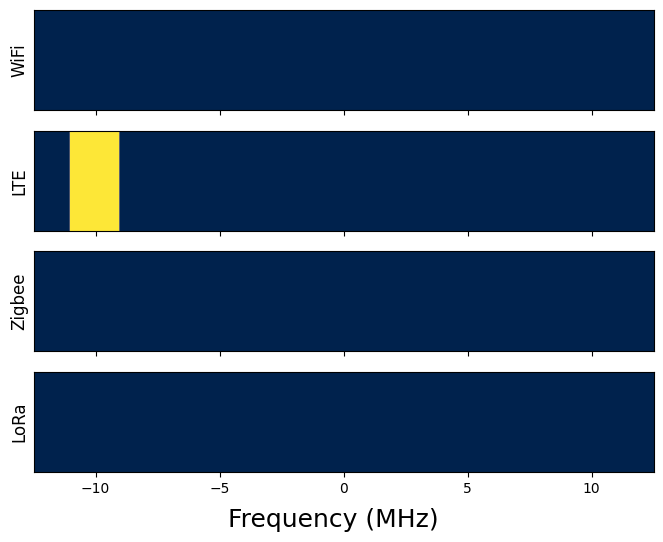

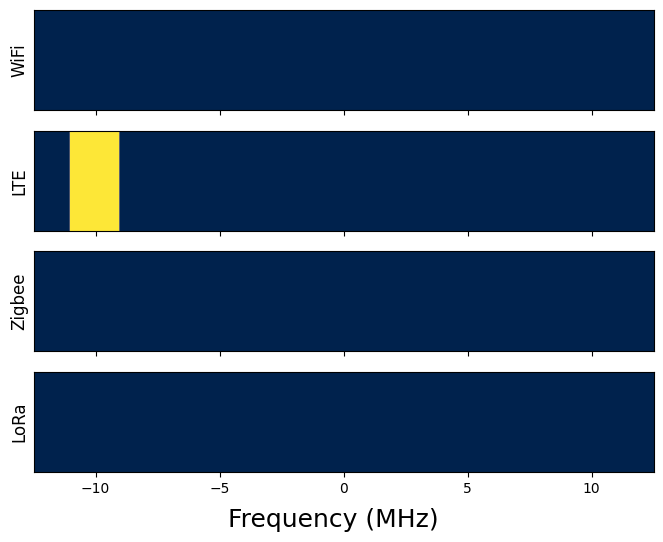

In [42]:
def test():
    model = U_Net(2,4,is_attention=True,alpha=1,beta=5)
    batchsize = 256
    ckpt = 'multilabel.pth'
    model.load_state_dict(torch.load(ckpt), strict=False)
    handler = TestHandler(model,device,testset,batchsize)
    iou, recall, precision = handler.evaluate()
    handler.display(2)
    print('iou:',iou)
    print('precision:',precision)
    print('recall:',recall)

test()